Library

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sqlalchemy import create_engine
from sklearn.model_selection import KFold
import psutil

Koneksi ke Database

In [27]:
engine = create_engine("mysql+pymysql://root:@localhost/magang")
query = """
SELECT waktu, voltage, current, power, frequency, powerfactor
FROM meter_1
"""
df = pd.read_sql(query, con=engine)
df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')
print(f"Jumlah Baris = {df.shape[0]}")
display(df.head())


Jumlah Baris = 3100


,voltage,current,power,frequency,powerfactor
waktu,,,,,
2025-01-28 07:41:46,380.78,32.03,20.58,49.98,0.97
2025-01-28 07:41:48,380.78,32.03,20.52,49.98,0.97
2025-01-28 07:41:55,380.35,31.99,20.52,49.98,0.97
2025-01-28 07:42:01,380.35,31.99,20.53,49.98,0.97
2025-01-28 07:42:04,380.49,31.97,20.53,49.99,0.97


Visualisasi Data Awal

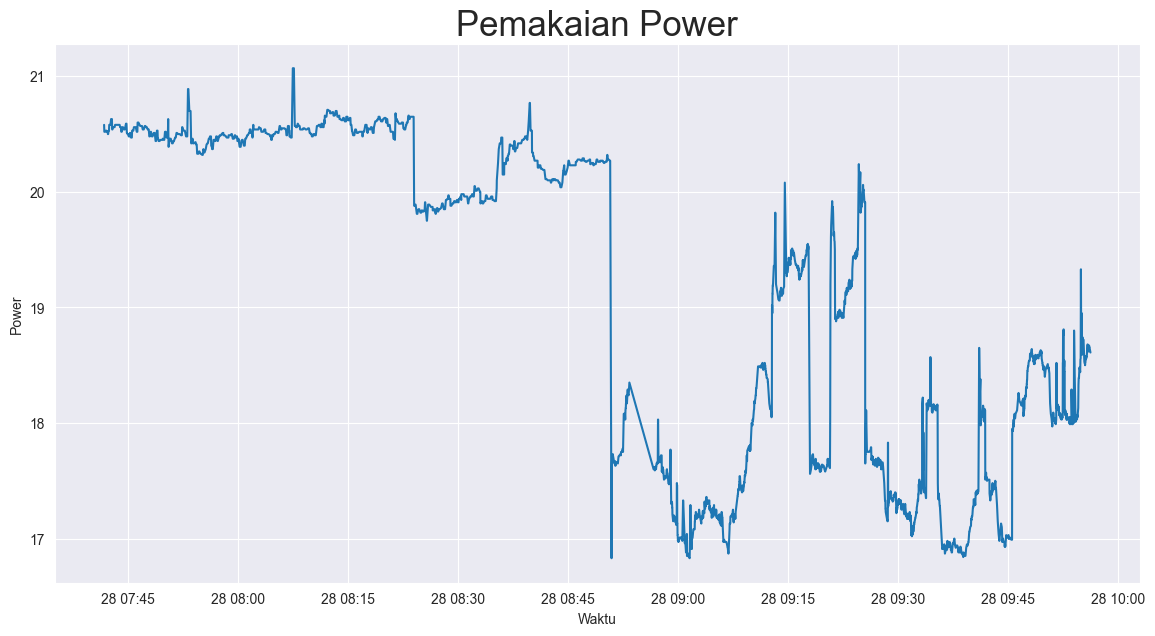

In [28]:
plt.figure(figsize=(14, 7))
sns.set_style('darkgrid')
plt.plot(df.index, df['power'])
plt.title("Pemakaian Power", fontsize=25)
plt.xlabel("Waktu")
plt.ylabel("Power")
plt.show()

Preprocessing

In [29]:
print(df.isnull().sum())
df.dropna(inplace=True)


X = df.drop(columns='power').to_numpy()
y = df['power'].to_numpy()

voltage        0
current        0
power          0
frequency      0
powerfactor    0
dtype: int64


K-fold validation

In [30]:
# Inisialisasi list untuk menyimpan metrik
mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores, mem_used_scores = [], [], [], [], [], []

process = psutil.Process()

# KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Cek memory sebelum training
    mem_before = process.memory_info().rss / (1024 ** 2)  # MB

    # Model
    model = ExtraTreesRegressor(n_estimators=1000, random_state=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Cek memory sesudah training
    mem_after = process.memory_info().rss / (1024 ** 2)  # MB
    mem_used = mem_after - mem_before
    mem_used_scores.append(mem_used)  # simpan ke list

    # Evaluasi
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2_scores.append(r2)

    print(f"Fold {fold}: "
          f"MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, "
          f"MAPE={mape:.2f}%, R²={r2:.4f}, "
          f"Mem Used={mem_used:.2f} MB")

Fold 1: MSE=0.0234, RMSE=0.1529, MAE=0.0594, MAPE=0.31%, R²=0.9856, Mem Used=212.95 MB
Fold 2: MSE=0.0089, RMSE=0.0944, MAE=0.0429, MAPE=0.24%, R²=0.9943, Mem Used=1.72 MB
Fold 3: MSE=0.0393, RMSE=0.1983, MAE=0.0648, MAPE=0.35%, R²=0.9748, Mem Used=-0.87 MB
Fold 4: MSE=0.0067, RMSE=0.0819, MAE=0.0394, MAPE=0.21%, R²=0.9955, Mem Used=0.37 MB
Fold 5: MSE=0.0112, RMSE=0.1056, MAE=0.0494, MAPE=0.26%, R²=0.9927, Mem Used=-0.45 MB
Fold 6: MSE=0.0137, RMSE=0.1172, MAE=0.0477, MAPE=0.26%, R²=0.9915, Mem Used=-0.20 MB
Fold 7: MSE=0.0081, RMSE=0.0903, MAE=0.0428, MAPE=0.23%, R²=0.9948, Mem Used=-0.07 MB
Fold 8: MSE=0.0200, RMSE=0.1416, MAE=0.0534, MAPE=0.29%, R²=0.9884, Mem Used=-0.67 MB
Fold 9: MSE=0.0287, RMSE=0.1694, MAE=0.0546, MAPE=0.30%, R²=0.9816, Mem Used=2.18 MB
Fold 10: MSE=0.0142, RMSE=0.1190, MAE=0.0458, MAPE=0.25%, R²=0.9901, Mem Used=-0.82 MB


Rata-rata k-fold

In [32]:
# === Rata-rata hasil ===
print("\n📊 Rata-rata Hasil K-Fold Cross Validation (10-fold):")
print(f"- Mean Squared Error (MSE)              : {np.mean(mse_scores):.4f}")
print(f"- Root Mean Squared Error (RMSE)        : {np.mean(rmse_scores):.4f}")
print(f"- Mean Absolute Error (MAE)             : {np.mean(mae_scores):.4f}")
print(f"- Mean Absolute Percentage Error (MAPE) : {np.mean(mape_scores):.2f}%")
print(f"- R-squared (R² Score)                  : {np.mean(r2_scores):.4f}")
print(f"- Rata-rata Memori Terpakai             : {np.mean(mem_used_scores):.2f} MB")


📊 Rata-rata Hasil K-Fold Cross Validation (10-fold):
- Mean Squared Error (MSE)              : 0.0174
- Root Mean Squared Error (RMSE)        : 0.1270
- Mean Absolute Error (MAE)             : 0.0500
- Mean Absolute Percentage Error (MAPE) : 0.27%
- R-squared (R² Score)                  : 0.9889
- Rata-rata Memori Terpakai             : 21.42 MB
